# Regression of Used Car Prices Dataset
Run after following notebooks are run:
1. **01_Data_Cleaning**
2. **02_EDA**

## Development Notes/Ideas
- ~~rf~~ - cannot use as would have to OHE
- ~~xgb~~ - cannot use as would have to OHE
- lightgbm
- catboost
- stack


## Libraries

In [1]:
## set up libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import catboost as cb
import shap
from sklearn.model_selection import StratifiedKFold

## Load Data

In [2]:
train = pd.read_pickle('train_fe.pkl')
test = pd.read_pickle('test_fe.pkl')

## separate in to features and response variable
x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test

## Modelling

### LightGBM

In [3]:
## LGBM specific data format
dataset_train = lgb.Dataset(x_train, label=y_train)

## instantiate rf algorithm, using optuna parameters
params = {"verbosity": -1,
        "objective": "regression",
        "metric": "rmse",
        "boosting": "gbdt",
        "learning_rate": 0.002945713769234241,
        "lambda_l1": 0.30000554925347156,
        "lambda_l2": 0.0001890717918321019,
        "num_leaves": 354,
        "feature_fraction": 0.7107068853312993,
        "bagging_fraction": 0.4061813540007248,
        "bagging_freq": 7,
        "max_depth": 6,
        "seed": 888,
        "num_threads": 6
}

## fit model to training data
lgbm = lgb.train(train_set=dataset_train, params=params, num_boost_round=1000)

In [4]:
## cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)

lgbm_cv = lgb.cv(train_set=dataset_train, params=params, folds=kf, metrics='rmse', num_boost_round=1000); None
print('\n cv rmse:', lgbm_cv['valid rmse-mean'][-1])

c:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



 cv rmse: 73225.29285830766


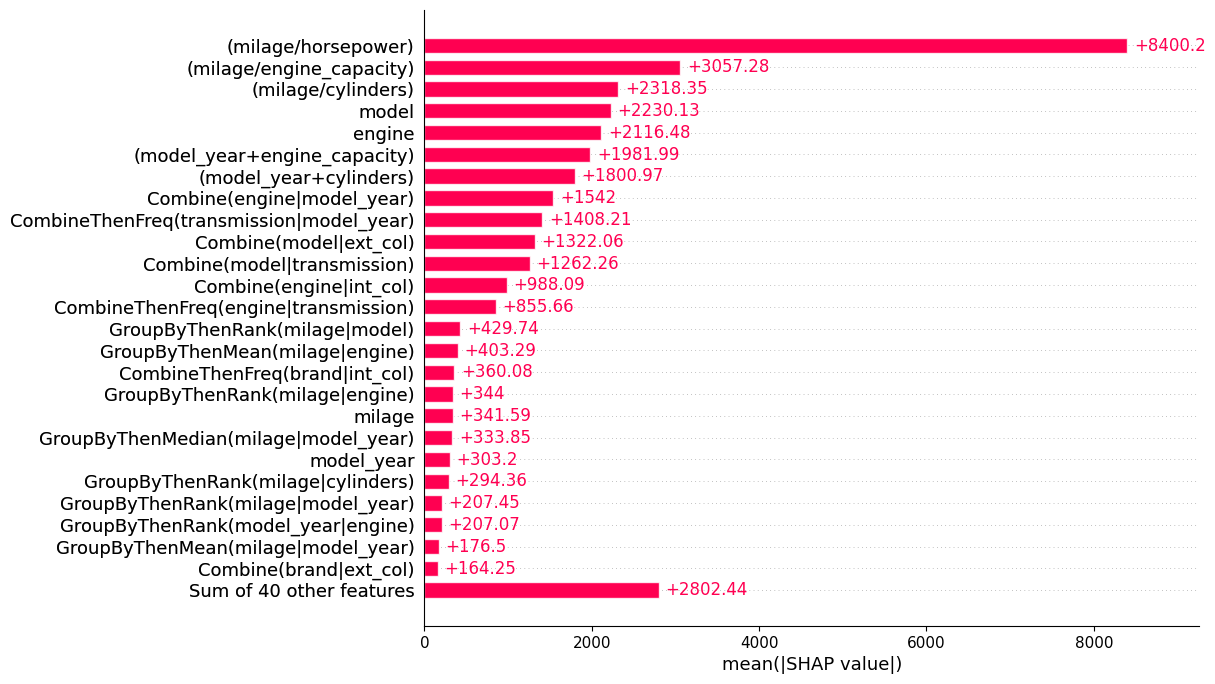

In [5]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer(x_train)

fig, ax=plt.subplots(figsize=(10,8))
shap.plots.bar(shap_values, max_display=26, ax=ax)


## CatBoost

In [7]:
## Catboost specific data format
cols_cat = x_train.columns[x_train.dtypes=='category'].to_list()
pool_train = cb.Pool(x_train, label=y_train, cat_features=cols_cat)


## instantiate catboost algorithm, using default parameters
params = {"verbose": False,
        "objective": "RMSE",
        "eval_metric": "RMSE",
        "boosting_type": "Plain",        
        "learning_rate": 0.07838264089680588,
        "l2_leaf_reg": 0.005458557526813314,
        "rsm": 0.7297540654978769,
        "subsample": 0.5346267592663484,
        "min_data_in_leaf": 82,
        "max_depth": 4,
        "grow_policy": "Lossguide",
        "num_leaves": 39,
        "random_seed": 888,
        "thread_count": 8
}

## fit model to training data
catb = cb.CatBoostRegressor(**params, num_boost_round=1000)
catb.fit(pool_train)

In [8]:
## cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)

catb_cv = cb.cv(pool=pool_train, params=params, folds=kf,  num_boost_round=1000); None
print('\n cv rmse:', catb_cv['test-RMSE-mean'].iloc[-1])

c:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training on fold [0/5]

bestTest = 73901.28669
bestIteration = 127

Training on fold [1/5]

bestTest = 72040.58771
bestIteration = 497

Training on fold [2/5]

bestTest = 72530.11847
bestIteration = 165

Training on fold [3/5]

bestTest = 72093.03486
bestIteration = 93

Training on fold [4/5]

bestTest = 72327.49288
bestIteration = 102


 cv rmse: 73352.30595105706


## Test Predictions

In [6]:
## set up submission format
submission = pd.read_csv('01_Data/sample_submission.csv')
submission['price'] = 0

,price_prediction
count,125690.000000
mean,43643.625980
std,29583.104718
min,-688.390992
25%,21964.745273
50%,37262.670420
75%,55872.711517
max,554823.739207


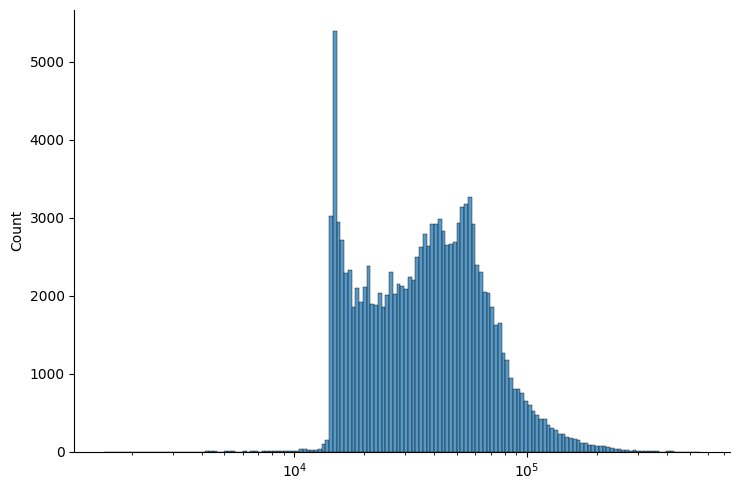

In [7]:
## lgbm prediction
y_testpred_lgbm = lgbm.predict(x_test)
submission['price'] = y_testpred_lgbm
submission.to_csv('02_Submissions/test_pred_lgbm_v2.csv', index=False)

## check prediction distribution
sns.displot(y_testpred_lgbm, aspect=1.5, log_scale=True)
pd.DataFrame({'price_prediction':y_testpred_lgbm}).describe()

,price_prediction
count,1.256900e+05
mean,4.389347e+04
std,3.472543e+04
min,-2.836869e+04
25%,1.997472e+04
50%,3.661942e+04
75%,5.798144e+04
max,1.204771e+06


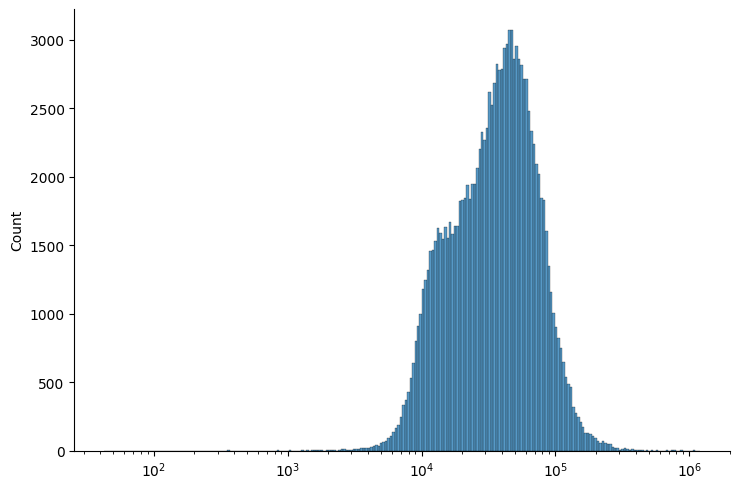

In [10]:
## catb prediction
y_testpred_catb = catb.predict(x_test)
submission['price'] = y_testpred_catb
submission.to_csv('02_Submissions/test_pred_catb_v2.csv', index=False)

## check prediction distribution
sns.displot(y_testpred_catb, aspect=1.5, log_scale=True)
pd.DataFrame({'price_prediction':y_testpred_catb}).describe()